# Training a Siamese model on MNIST dataset using PyTorch and supervized learning

In this notebook, you can find the example code for this repo (https://github.com/ziadloo/Self-Supervised-Learning-vs-Supervised-Learning) that trains a Siamese model using supervised learning over the MNIST dataset. You can also find in-depth explanation on this topic on this [article]().

Let's start by installing and then loading the needed libraries.

In [1]:
# !pip install git+https://github.com/ziadloo/Siamese-model-in-Pytorch.git

In [2]:
import torch
from torch import nn
import torchvision
import random
import copy
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import plotly.graph_objs as go

import sys
import os

# Add the path of the parent directory to sys.path
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)

# Now you can perform relative imports
from Siamese import SiameseDataLoader, SiameseSampleGenerator, SiameseDataset, SiameseModel, triplet_loss, info_nce_loss

torch.manual_seed(42)
random.seed(42)

/home/mehran/.conda/envs/whisper/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/mehran/.conda/envs/whisper/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## Loading the dataset

First, we need to load the MNIST dataset. PyTorch has helper method to make it easy.

In [3]:
training_mnist = datasets.MNIST(
    root="data",
    train=True,
    download=True,
)

test_mnist = datasets.MNIST(
    root="data",
    train=False,
    download=True,
)

A Siamese model when trained in a supervised paradigm consumes the data in a very specific way. Each mini-batch should be composed of two tensors. Both of these tensors should be the same shape as of your dataset. For example, in the case of MNIST, each sample is an image of 28*28 pixels. Here, as part of the augmentation we will be upscaling them to 32*32. So each input sample is a 1*32*32 tensor. The first 1 is because the images are grayscale.

In our case, if want to have batches of size `b`, each batch will be: `(b*1*32*32, b*1*32*32)`. Meaning each training input will be tuple of two tensors. Each tensor will be of shape `b*1*32*32`. But there's more, the samples in each batch will of the same class as of other batch while no other sample in the batch should of that class. This is depicted in the following image:

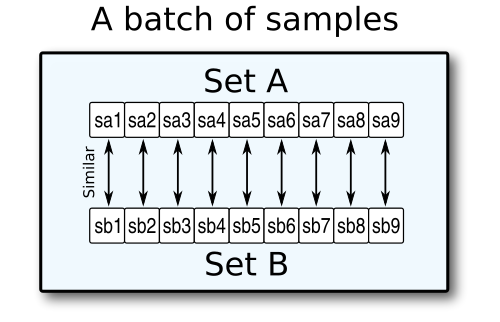

The formal mathematical way of saying the same thing is:

\begin{equation}
  \forall i, j \in B, \begin{cases}
    \text{class(sa[i]) $=$ class(sb[j])}, \:\: & \text{if $i = j$}\\
    \text{class(sa[i]) $\neq$ class(sb[j])}, \:\: & \text{if $i \neq j$} &
  \end{cases}
\end{equation}

The direct result of the above assumption is that the `batch_size` cannot be larger than the number of classes that we have. So here, `batch_size` could be as large as 10. I would like to reiterate that this restriction is only applicable to *supervised learning* version of a Siamese model. This does not apply once we are talking about *self-supervised learning*.

This requirement is satisfied by the classes implemented in this repo seemlessly. All you need to do is to sub-class `SiameseSampleGenerator` to generate samples of a single class per each call. Here's our implementation for MNIST:

In [4]:
class MnistGenerator(SiameseSampleGenerator):
    def __init__(self, ds, transform=None):
        self.samples = ds
        random.shuffle(self.samples)
        self.counter = 0
        self.transform = transform

    def shuffle(self):
        random.shuffle(self.samples)

    def __call__(self):
        curr = self.counter
        self.counter = (self.counter + 1) % len(self.samples)
        if self.transform is not None:
            return self.transform(self.samples[curr])
        else:
            return self.samples[curr]

Having grouped the samples by their class/label, the `MnistGenerator` class will return one sample of a specific class when called. Then, the `SiameseDataset` class will use these generators to compose batches of data match the structure explained above.

In [5]:
batch_size = 10
class_count = 10

assert batch_size <= class_count


train_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomAffine((-10, 10), (0.1, 0.1), (0.8, 1.2), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

train_samples = [[] for i in range(10)]
for X, y in training_mnist:
    train_samples[y].append(X)

test_samples = [[] for i in range(10)]
for X, y in test_mnist:
    test_samples[y].append(X)

# Train dataloader
training_generators = [MnistGenerator(train_samples[i], train_transform) for i in range(class_count)]
training_data = SiameseDataset(len(train_samples[0]), training_generators)
train_dataloader = SiameseDataLoader(training_data, batch_size=batch_size, class_count=class_count)

# Test dataloader
test_generators = [MnistGenerator(test_samples[i], test_transform) for i in range(class_count)]
test_data = SiameseDataset(len(test_samples[0]), test_generators)
test_dataloader = SiameseDataLoader(test_data, batch_size=batch_size, class_count=class_count)

## Tower design

Next, we'll define our tower model. Generally speaking, the design of the tower model is irrelevant to the Siamese model. Except fo the following requirements:

1. Make sure the input shape for the tower matches the dataset samples. To be clear, the input shape of the tower should match `sa1` in the explained example above and *not* `(sa1, sb1)`.
2. The output shape of the tower should be a one dimensional vector of your desired length. The number of elements in the vector represents the latent space that you are encoding your input into.
3. The last requirement is very important. The output vector of the tower should be of magnitute of `1`.

As long as the tower model satisfies the three conditions above, the rest of its design is arbitrary. In case of our example here, since we are dealing with images, CNN is preferred way of choice.

In [6]:
class MnistCnn(nn.Module):
    def __init__(self, latent_size):
        super(MnistCnn, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.linear = nn.Sequential(
            nn.Linear(32 * 8 * 8, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Linear(2048, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(),
        )
        self.fc = nn.Linear(4096, latent_size)

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        x = self.fc(x)
        return x

Next, we'll instantiate an object from the tower and wrap it in a Siamese model.

In [7]:
# Tower model
latent_size = 3
tower = MnistCnn(latent_size)
# Siamese model
siamese = SiameseModel(tower)

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")
print(siamese)

Using cuda device
SiameseModel(
  (tower): MnistCnn(
    (cnn): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (linear): Sequential(
      (0): Linear(in_features=2048, out_features=2048, bias=True)
      (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=2048, out_features=4096, bias=True)
      (4): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (fc): Linear(in_features=4096, out_features=3, bias=True)
  )
)


## Training the model

The training step of a Siamese model is exactly the same as any ordinary model. The only difference is that the dataloader as well as the model deal with the data in pairs.

In [8]:
def train(dataloader, model, loss_fn, regularization, optimizer, device):
    size = len(dataloader.dataset)
    model.train()
    total_loss = 0
    total_counter = 0
    # The only difference is that the dataloader will return a tuple (s1, s2)
    for batch, (s1, s2) in enumerate(dataloader):
        s1, s2 = s1.to(device), s2.to(device)

        # Compute prediction error
        o1, o2 = model((s1, s2))
        v1 = nn.functional.normalize(o1, dim=-1)
        v2 = nn.functional.normalize(o2, dim=-1)
        loss = loss_fn(v1, v2) + regularization(o1, o2)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()
        total_counter += 1

    total_loss += loss.item()
    total_counter += 1
    total_loss /= total_counter

    return total_loss


def test(dataloader, model, loss_fn, device):
    def accuracy(v1, v2):
        scores = torch.mm(v1, v2.t())
        m = torch.argmax(scores, dim=-1).to(v1.device)
        i = torch.arange(len(m)).to(v1.device)
        mark_list = torch.where(i == m, torch.tensor(1).to(v1.device), torch.tensor(0).to(v1.device))
        mark = torch.sum(mark_list).to(v1.device)
        return mark / len(mark_list)

    size = len(dataloader.dataset)
    model.eval()
    test_loss = 0
    test_acc = 0
    num_batches = 0
    with torch.no_grad():
        for s1, s2 in dataloader:
            s1, s2 = s1.to(device), s2.to(device)
            o1, o2 = model((s1, s2))
            v1 = nn.functional.normalize(o1, dim=-1)
            v2 = nn.functional.normalize(o2, dim=-1)
            test_loss += loss_fn(v1, v2)
            test_acc += accuracy(v1, v2)
            num_batches += 1
    test_loss /= num_batches
    test_acc /= num_batches

    return test_loss, test_acc

In [9]:
def no_regularization(o1, o2):
    return 0.0

def norm_regularization_1_l1(o1, o2):
    outputs = torch.cat([o1, o2], dim=0)
    normed = torch.nn.functional.normalize(outputs, dim=-1)
    dist = torch.abs(outputs - normed)
    return dist.mean()


def norm_regularization_1_l2(o1, o2):
    outputs = torch.cat([o1, o2], dim=0)
    normed = torch.nn.functional.normalize(outputs, dim=-1)
    dist = torch.square(outputs - normed)
    return dist.mean().sqrt()


def norm_regularization_2_l1(o1, o2):
    outputs = torch.cat([o1, o2], dim=0)
    vec_size = torch.sqrt(torch.sum(outputs * outputs, dim=-1, keepdim=True))
    dist = torch.abs(vec_size - 1.0)
    return dist.mean()


def norm_regularization_2_l2(o1, o2):
    outputs = torch.cat([o1, o2], dim=0)
    vec_size = torch.sqrt(torch.sum(outputs * outputs, dim=-1, keepdim=True))
    dist = torch.square(vec_size - 1.0)
    return dist.mean().sqrt()

The only thing left is to train the model.

In [10]:
def train_tower(loss_fn, regularization):
    tower = MnistCnn(latent_size)
    # Siamese model
    siamese = SiameseModel(tower).to(device)
    
    optimizer = torch.optim.SGD(siamese.parameters(), lr=1e-3, momentum=0.7)
    
    best_tower = MnistCnn(latent_size)
    best_acc = 0
    epochs = 20
    for t in range(epochs):
        print("--------------------------------------------------------------------------------")
        print(f"Epoch {t+1}/{epochs}")
        train_loss = train(train_dataloader, siamese, loss_fn, regularization, optimizer, device)
        test_loss, test_acc = test(test_dataloader, siamese, loss_fn, device)
    
        print(f"Train Loss: {train_loss:>7f} \t Test Avg Loss: {test_loss:>8f} \t Test Avg Acc: {test_acc:>8f}")
        
        if test_acc > best_acc:
            best_acc = test_acc
            best_tower.load_state_dict(copy.deepcopy(siamese.tower.state_dict()))

    return best_tower, best_acc
    
    print("--------------------------------------------------------------------------------")
    print("Training is done!")

In [11]:
def plot_test_data(tower, title, best_acc, project_on_sphere=False):
    val_mnist = datasets.MNIST(
        root="data",
        train=False,
        download=True,
        transform=test_transform,
    )
    
    valLoader = DataLoader(val_mnist,
        batch_size=64,
        shuffle=False,
        num_workers=2,
        prefetch_factor=100
    )
    
    encoded_data = []
    labels = []
    
    with torch.no_grad():
        for X, y in valLoader:
            output = tower(X)
            if project_on_sphere:
                output = nn.functional.normalize(output, dim=-1)
            encoded_data.extend(output.cpu().numpy())
            labels.extend(y.cpu().numpy())
    
    encoded_data = np.array(encoded_data)
    labels = np.array(labels)

    scatter = go.Scatter3d(
        x=encoded_data[:, 0],
        y=encoded_data[:, 1],
        z=encoded_data[:, 2],
        mode='markers',
        marker=dict(size=2, color=labels, colorscale='Viridis', opacity=0.8),
        text=labels, 
        hoverinfo='text',
    )
    
    # Create layout
    layout = go.Layout(
        title=f"{title} (best accuracy on MNIST dataset: {best_acc*100:.3f}%)",
        scene=dict(
            xaxis=dict(title="Latent Dimension 1"),
            yaxis=dict(title="Latent Dimension 2"),
            zaxis=dict(title="Latent Dimension 3"),
        ),
    )
    
    # Create figure and add scatter plot
    fig = go.Figure(data=[scatter], layout=layout)
    
    # Show the plot
    # fig.show()
    fig.write_html(f"./charts/{title}.html", auto_open=True)

Now we can use our trained model and generate the embeddings for each of the samples. Once we have the embeddings, a simple matrix multiplication will give us the cosine distance between any two samples.

In [12]:
tower, best_acc = train_tower(triplet_loss, no_regularization)
plot_test_data(tower, "Triplet loss function with no regularization", best_acc)
plot_test_data(tower, "Triplet loss function with no regularization projected onto sphere", best_acc, project_on_sphere=True)

--------------------------------------------------------------------------------
Epoch 1/20
Train Loss: 1.634827 	 Test Avg Loss: 1.017131 	 Test Avg Acc: 0.665306
--------------------------------------------------------------------------------
Epoch 2/20
Train Loss: 1.082375 	 Test Avg Loss: 0.921076 	 Test Avg Acc: 0.752041
--------------------------------------------------------------------------------
Epoch 3/20
Train Loss: 0.966656 	 Test Avg Loss: 0.845664 	 Test Avg Acc: 0.819388
--------------------------------------------------------------------------------
Epoch 4/20
Train Loss: 0.907769 	 Test Avg Loss: 0.758578 	 Test Avg Acc: 0.898980
--------------------------------------------------------------------------------
Epoch 5/20
Train Loss: 0.841190 	 Test Avg Loss: 0.742853 	 Test Avg Acc: 0.924490
--------------------------------------------------------------------------------
Epoch 6/20
Train Loss: 0.800408 	 Test Avg Loss: 0.723338 	 Test Avg Acc: 0.931633
----------------

In [13]:
tower, best_acc = train_tower(triplet_loss, norm_regularization_1_l1)
plot_test_data(tower, "Triplet loss function with normalization regularization (type 1 + L1)", best_acc)
plot_test_data(tower, "Triplet loss function with normalization regularization (type 1 + L1) projected onto sphere", best_acc, project_on_sphere=True)

--------------------------------------------------------------------------------
Epoch 1/20
Train Loss: 2.386195 	 Test Avg Loss: 1.528862 	 Test Avg Acc: 0.416326
--------------------------------------------------------------------------------
Epoch 2/20
Train Loss: 2.081919 	 Test Avg Loss: 1.146600 	 Test Avg Acc: 0.675510
--------------------------------------------------------------------------------
Epoch 3/20
Train Loss: 1.779183 	 Test Avg Loss: 1.042387 	 Test Avg Acc: 0.704082
--------------------------------------------------------------------------------
Epoch 4/20
Train Loss: 1.640846 	 Test Avg Loss: 1.333198 	 Test Avg Acc: 0.666327
--------------------------------------------------------------------------------
Epoch 5/20
Train Loss: 1.527947 	 Test Avg Loss: 1.032391 	 Test Avg Acc: 0.728571
--------------------------------------------------------------------------------
Epoch 6/20
Train Loss: 1.533680 	 Test Avg Loss: 1.074842 	 Test Avg Acc: 0.654082
----------------

In [14]:
tower, best_acc = train_tower(triplet_loss, norm_regularization_1_l2)
plot_test_data(tower, "Triplet loss function with normalization regularization (type 1 + L2)", best_acc)
plot_test_data(tower, "Triplet loss function with normalization regularization (type 1 + L2) projected onto sphere", best_acc, project_on_sphere=True)

--------------------------------------------------------------------------------
Epoch 1/20
Train Loss: 2.504698 	 Test Avg Loss: 1.722271 	 Test Avg Acc: 0.396939
--------------------------------------------------------------------------------
Epoch 2/20
Train Loss: 1.982308 	 Test Avg Loss: 1.234393 	 Test Avg Acc: 0.601020
--------------------------------------------------------------------------------
Epoch 3/20
Train Loss: 1.863082 	 Test Avg Loss: 1.425046 	 Test Avg Acc: 0.464286
--------------------------------------------------------------------------------
Epoch 4/20
Train Loss: 1.737730 	 Test Avg Loss: 1.056005 	 Test Avg Acc: 0.719388
--------------------------------------------------------------------------------
Epoch 5/20
Train Loss: 1.825165 	 Test Avg Loss: 1.208592 	 Test Avg Acc: 0.606122
--------------------------------------------------------------------------------
Epoch 6/20
Train Loss: 1.658907 	 Test Avg Loss: 1.072984 	 Test Avg Acc: 0.717347
----------------

In [15]:
tower, best_acc = train_tower(triplet_loss, norm_regularization_2_l1)
plot_test_data(tower, "Triplet loss function with normalization regularization (type 2 + L1)", best_acc)
plot_test_data(tower, "Triplet loss function with normalization regularization (type 2 + L1) projected onto sphere", best_acc, project_on_sphere=True)

--------------------------------------------------------------------------------
Epoch 1/20
Train Loss: 2.964958 	 Test Avg Loss: 1.861192 	 Test Avg Acc: 0.305102
--------------------------------------------------------------------------------
Epoch 2/20
Train Loss: 2.670221 	 Test Avg Loss: 1.738887 	 Test Avg Acc: 0.351020
--------------------------------------------------------------------------------
Epoch 3/20
Train Loss: 2.546780 	 Test Avg Loss: 1.471148 	 Test Avg Acc: 0.432653
--------------------------------------------------------------------------------
Epoch 4/20
Train Loss: 2.322819 	 Test Avg Loss: 1.472425 	 Test Avg Acc: 0.484694
--------------------------------------------------------------------------------
Epoch 5/20
Train Loss: 2.311443 	 Test Avg Loss: 1.304688 	 Test Avg Acc: 0.554082
--------------------------------------------------------------------------------
Epoch 6/20
Train Loss: 2.137204 	 Test Avg Loss: 1.304661 	 Test Avg Acc: 0.613265
----------------

In [16]:
tower, best_acc = train_tower(triplet_loss, norm_regularization_2_l2)
plot_test_data(tower, "Triplet loss function with normalization regularization (type 2 + L2)", best_acc)
plot_test_data(tower, "Triplet loss function with normalization regularization (type 2 + L2) projected onto sphere", best_acc, project_on_sphere=True)

--------------------------------------------------------------------------------
Epoch 1/20
Train Loss: 3.146405 	 Test Avg Loss: 1.858734 	 Test Avg Acc: 0.278571
--------------------------------------------------------------------------------
Epoch 2/20
Train Loss: 2.912144 	 Test Avg Loss: 1.544876 	 Test Avg Acc: 0.408163
--------------------------------------------------------------------------------
Epoch 3/20
Train Loss: 2.818736 	 Test Avg Loss: 1.751738 	 Test Avg Acc: 0.358163
--------------------------------------------------------------------------------
Epoch 4/20
Train Loss: 2.659382 	 Test Avg Loss: 1.524286 	 Test Avg Acc: 0.428571
--------------------------------------------------------------------------------
Epoch 5/20
Train Loss: 2.438941 	 Test Avg Loss: 1.254163 	 Test Avg Acc: 0.480612
--------------------------------------------------------------------------------
Epoch 6/20
Train Loss: 2.454201 	 Test Avg Loss: 1.444784 	 Test Avg Acc: 0.430612
----------------

In [17]:
tower, best_acc = train_tower(info_nce_loss, no_regularization)
plot_test_data(tower, "InfoNCE loss function with no regularization", best_acc)
plot_test_data(tower, "InfoNCE loss function with no regularization projected onto sphere", best_acc, project_on_sphere=True)

--------------------------------------------------------------------------------
Epoch 1/20
Train Loss: 1.848976 	 Test Avg Loss: 1.620070 	 Test Avg Acc: 0.645918
--------------------------------------------------------------------------------
Epoch 2/20
Train Loss: 1.660962 	 Test Avg Loss: 1.616102 	 Test Avg Acc: 0.697959
--------------------------------------------------------------------------------
Epoch 3/20
Train Loss: 1.624944 	 Test Avg Loss: 1.569342 	 Test Avg Acc: 0.817347
--------------------------------------------------------------------------------
Epoch 4/20
Train Loss: 1.606486 	 Test Avg Loss: 1.563362 	 Test Avg Acc: 0.816326
--------------------------------------------------------------------------------
Epoch 5/20
Train Loss: 1.592012 	 Test Avg Loss: 1.554415 	 Test Avg Acc: 0.854082
--------------------------------------------------------------------------------
Epoch 6/20
Train Loss: 1.581698 	 Test Avg Loss: 1.542469 	 Test Avg Acc: 0.879592
----------------

In [18]:
tower, best_acc = train_tower(info_nce_loss, norm_regularization_1_l1)
plot_test_data(tower, "InfoNCE loss function with normalization regularization (type 1 + L1)", best_acc)
plot_test_data(tower, "InfoNCE loss function with normalization regularization (type 1 + L1) projected onto sphere", best_acc, project_on_sphere=True)

--------------------------------------------------------------------------------
Epoch 1/20
Train Loss: 2.215929 	 Test Avg Loss: 1.733536 	 Test Avg Acc: 0.605102
--------------------------------------------------------------------------------
Epoch 2/20
Train Loss: 2.006292 	 Test Avg Loss: 1.674307 	 Test Avg Acc: 0.656122
--------------------------------------------------------------------------------
Epoch 3/20
Train Loss: 1.900822 	 Test Avg Loss: 1.644840 	 Test Avg Acc: 0.710204
--------------------------------------------------------------------------------
Epoch 4/20
Train Loss: 1.866944 	 Test Avg Loss: 1.629675 	 Test Avg Acc: 0.728571
--------------------------------------------------------------------------------
Epoch 5/20
Train Loss: 1.832375 	 Test Avg Loss: 1.601139 	 Test Avg Acc: 0.737755
--------------------------------------------------------------------------------
Epoch 6/20
Train Loss: 1.786305 	 Test Avg Loss: 1.689643 	 Test Avg Acc: 0.722449
----------------

In [19]:
tower, best_acc = train_tower(info_nce_loss, norm_regularization_1_l2)
plot_test_data(tower, "InfoNCE loss function with normalization regularization (type 1 + L2)", best_acc)
plot_test_data(tower, "InfoNCE loss function with normalization regularization (type 1 + L2) projected onto sphere", best_acc, project_on_sphere=True)

--------------------------------------------------------------------------------
Epoch 1/20
Train Loss: 2.317214 	 Test Avg Loss: 1.793377 	 Test Avg Acc: 0.529592
--------------------------------------------------------------------------------
Epoch 2/20
Train Loss: 2.054616 	 Test Avg Loss: 1.833704 	 Test Avg Acc: 0.519388
--------------------------------------------------------------------------------
Epoch 3/20
Train Loss: 1.989758 	 Test Avg Loss: 1.690820 	 Test Avg Acc: 0.645918
--------------------------------------------------------------------------------
Epoch 4/20
Train Loss: 1.909677 	 Test Avg Loss: 1.650348 	 Test Avg Acc: 0.700000
--------------------------------------------------------------------------------
Epoch 5/20
Train Loss: 1.879954 	 Test Avg Loss: 1.641451 	 Test Avg Acc: 0.763265
--------------------------------------------------------------------------------
Epoch 6/20
Train Loss: 1.846934 	 Test Avg Loss: 1.609273 	 Test Avg Acc: 0.752041
----------------

In [20]:
tower, best_acc = train_tower(info_nce_loss, norm_regularization_2_l1)
plot_test_data(tower, "InfoNCE loss function with normalization regularization (type 2 + L1)", best_acc)
plot_test_data(tower, "InfoNCE loss function with normalization regularization (type 2 + L1) projected onto sphere", best_acc, project_on_sphere=True)

--------------------------------------------------------------------------------
Epoch 1/20
Train Loss: 2.563435 	 Test Avg Loss: 1.902799 	 Test Avg Acc: 0.350000
--------------------------------------------------------------------------------
Epoch 2/20
Train Loss: 2.358056 	 Test Avg Loss: 1.785590 	 Test Avg Acc: 0.490816
--------------------------------------------------------------------------------
Epoch 3/20
Train Loss: 2.150749 	 Test Avg Loss: 1.678371 	 Test Avg Acc: 0.572449
--------------------------------------------------------------------------------
Epoch 4/20
Train Loss: 2.080469 	 Test Avg Loss: 1.709545 	 Test Avg Acc: 0.560204
--------------------------------------------------------------------------------
Epoch 5/20
Train Loss: 2.136946 	 Test Avg Loss: 1.726653 	 Test Avg Acc: 0.604081
--------------------------------------------------------------------------------
Epoch 6/20
Train Loss: 2.001725 	 Test Avg Loss: 1.690856 	 Test Avg Acc: 0.634694
----------------

In [21]:
tower, best_acc = train_tower(info_nce_loss, norm_regularization_2_l2)
plot_test_data(tower, "InfoNCE loss function with normalization regularization (type 2 + L2)", best_acc)
plot_test_data(tower, "InfoNCE loss function with normalization regularization (type 2 + L2) projected onto sphere", best_acc, project_on_sphere=True)

--------------------------------------------------------------------------------
Epoch 1/20
Train Loss: 2.692227 	 Test Avg Loss: 1.968376 	 Test Avg Acc: 0.341837
--------------------------------------------------------------------------------
Epoch 2/20
Train Loss: 2.462798 	 Test Avg Loss: 1.820063 	 Test Avg Acc: 0.460204
--------------------------------------------------------------------------------
Epoch 3/20
Train Loss: 2.315378 	 Test Avg Loss: 1.863773 	 Test Avg Acc: 0.421429
--------------------------------------------------------------------------------
Epoch 4/20
Train Loss: 2.217998 	 Test Avg Loss: 1.708911 	 Test Avg Acc: 0.539796
--------------------------------------------------------------------------------
Epoch 5/20
Train Loss: 2.089804 	 Test Avg Loss: 1.705806 	 Test Avg Acc: 0.602041
--------------------------------------------------------------------------------
Epoch 6/20
Train Loss: 2.085631 	 Test Avg Loss: 1.711024 	 Test Avg Acc: 0.620408
----------------